# Classification Exercise - Tracy
### Rohin Mohanadas


__The Task__ : The task you are given is basically to use the data from _data.csv_ and perform some 
1.  Exploratory Data Analysis and
2.  Come up with a Classification Model 

I decided to split these tasks up and proceed step by step. To perform step 1, my first thought was to glance through the _data.csv_ and find out if there were any obvious patterns. Being a huge data sample with ~500 thousand records, this effort was abandoned immediately. But this glance helped me find some data corruptions that I think might have occurred during aggregating multiple data sets into a single csv. The header columns reappeared at multiple locations of the file which was pretty straightforward to fix.

I have imported a number of libraries the use of which would become clear as we proceed with the codeflow.

In [53]:
%matplotlib notebook
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.covariance import EllipticEnvelope
#from sklearn import svm
from mpl_toolkits.mplot3d import Axes3D

## Importing the data

Once the obvious anomaly was corrected, the next step was to check data for gaps and fill the gaps using a suitable extrapolation ( Like record removal, column mean, median or mode or even use a different predictive model ).

Fortunately in our case, there are no missing values in the accelerometer data and the labels.

In [54]:
df = pd.read_csv('/home/tracy/notebooks/rohin/data/data.csv',usecols=[0,1,2,6])
df

,xAcc,yAcc,zAcc,superpattern
0,-0.129,-0.219,0.502,1
1,-0.067,-0.240,0.558,1
2,-0.101,-0.290,0.493,1
3,-0.309,-0.223,0.470,1
4,-0.586,-0.053,0.390,1
5,-0.475,-0.094,0.247,1
6,-0.383,0.007,0.338,1
7,-0.520,0.059,0.481,1
8,-0.445,-0.076,0.361,1
9,-0.276,-0.308,0.248,1


## Visualizing the data

Once the data has been imported using pandas. My next plan of action was to visualize it and make sense of the distributions of the different classes. For this purpose, I am using the __[mplot3d](http://matplotlib.org/mpl_toolkits/mplot3d/)__ toolkit and creating a scatterplot to make sense of the data that was provided. The colors correspond to 
1. B = 0 (rest) 
2. G = 1 (walk) 
3. R = 2 (run)

The visualization makes sense because the points which have low accelerometer values are the ones at the middle of the clump of data, which in turn means, during rest, the subject makes the lowest amount of motion. But run and walk are not so intuitive.

<IPython.core.display.Javascript object>


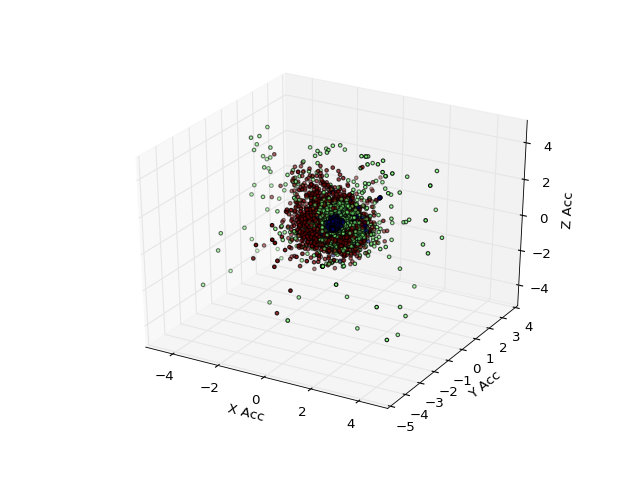

In [55]:
fig = plt.figure()
bx = fig.add_subplot(111, projection='3d')
bx.scatter(xs=df['xAcc'],ys=df['yAcc'],zs=df['zAcc'], zdir='z', s=10, c=df['superpattern']) 
bx.set_xlabel('X Acc')
bx.set_ylabel('Y Acc')
bx.set_zlabel('Z Acc')

## Outliers

Aside from the understanding how the classes stand in comparison to each other, it is noteworthy that some data points seem to stray from the generic distribution. Such data points are often referred to as outliers and are known to make the process of devising a good classifier hard.

But scikit-learn provides some excellent tools to detect and filter out outliers so that our job is made easy. I will be using __[covariance.EllipticEnvelope](http://scikit-learn.org/stable/modules/outlier_detection.html#fitting-an-elliptic-envelope)__ to compute the Mahalanobis distance of data point which is a measure of its "outlyingness".

In [56]:
EE = EllipticEnvelope(contamination=0.1)
arr = np.column_stack((df['xAcc'].tolist(),df['yAcc'].tolist(),df['zAcc'].tolist()))

# used to build the 3d graph with outliers filtered out.
fullarr = np.column_stack((df['xAcc'].tolist(),df['yAcc'].tolist(),df['zAcc'].tolist(),df['superpattern'].tolist()))


### Removing outliers from training data

Now we fit our input data with the Elliptic Envelope and use it to compute the Mahalanobis distance. I have used 700 as the parameter beyond which we consider datapoints as outliers. This value should ideally be tweaked to obtain ideal performance. Thus we build the subset of the data which are not outliers according to the Elliptic Envelope fit.

In [57]:

EE.fit(X=arr)

corrected = EE.correct_covariance(data=arr)
# calculate mahalanobis distance of each data point
maha = EE.mahalanobis(arr)
ans = np.where(maha<700)
newans = fullarr[ans]

### Verifiying results of outlier removal

Once we have removed the outliers, we can see how the new visualization of the data points look. Let us have a look.

<IPython.core.display.Javascript object>


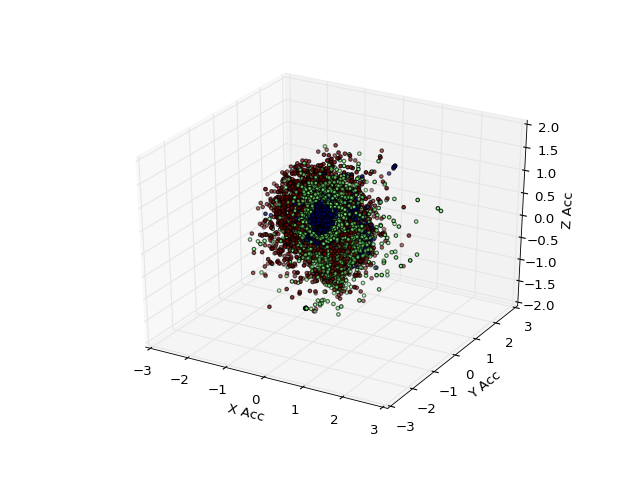

In [58]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=newans[:,0],ys=newans[:,1],zs=newans[:,2], zdir='z', s=10, c=newans[:,3]) 
ax.set_xlabel('X Acc')
ax.set_ylabel('Y Acc')
ax.set_zlabel('Z Acc')

The results are very much apparent as the scatter has now reduced and the points now seem more coherent. With this in place, we proceed to the next important step.

## Building train and test Sets

Now we have come to the point where we can separate the dump of data that we have and randomly select training and testing subsets from them. Again, we make use of  scikit-learn's *train\_test\_split* which easily accomplishes this task.

In [59]:
X = newans[:,0:3]
y = newans[:,3]
# Creating training to test with ratio 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

## Selecting and training a model

In selecting a model for the classification, I used scikit-learn __[cheatsheet](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)__ and attemped a classification using SVM to begin with. This turned out to be infeasible because I had chosen the default kernel (RBF) and the model seemed to take forever to learn. Then I moved on to ensemble models and chose _[Random Forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)_ which runs really fast for the amount of data thrown at it.



In [60]:
clf = RandomForestClassifier(min_samples_leaf=20)
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
print("Random Forest: training time", end - start, "seconds with test accuracy: ",clf.score(X_test,y_test)*100,"%")

Random Forest: training time 3.950488567352295 seconds with test accuracy:  90.4109176054 %
